# Neural Network implementation

### Library imports

In [2]:
# General Libraries
import pandas as pd
import numpy as np
import re
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Miscellaneous
import joblib
import copy
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### Load and explore dataset

In [3]:
# Define the path to your dataset
data_path = 'normalized_and_tokenized_combined_data.xlsx'

# Load the dataset
df = pd.read_excel(data_path)

print("First few rows of the dataset:")
print(df.head())

print("\nData types of each column:")
print(df.dtypes)

print("\nMissing values in each column:")
print(df.isnull().sum())

print("\nNumber of duplicated rows:", df.duplicated().sum())

df = df.drop_duplicates()
print("Dataset shape after removing duplicates:", df.shape)

First few rows of the dataset:
     id                                              title  \
0   526   یوٹیلیٹی اسٹورز پر چینی کی قیمت میں کمی کردی گئی   
1  1462            ایڈیلیڈ میچ کے ہیرو حارث رؤف کی سالگرہ   
2  1515  ’’پیگماٹائٹ‘‘ یہ نایاب پتھروں اور غیرمعمولی عن...   
3  1656  جوبائیڈن کا ڈونلڈ ٹرمپ کو فون، جیت پر مبارک با...   
4  1840             پاکستان میں آج سونے کی قیمت کیا رہی ؟   

                                 link  \
0  https://urdu.geo.tv/latest/385946-   
1    https://jang.com.pk/news/1409128   
2    https://jang.com.pk/news/1309594   
3    https://jang.com.pk/news/1408469   
4    https://urdu.samaa.tv/2087324435   

                                             content          gold_label  \
0  اسلام آباد: یوٹیلیٹی اسٹورز کارپوریشن نے چینی...            business   
1  قومی کرکٹ ٹیم کے فاسٹ بولر اور آسٹریلیا کے خل...              sports   
2  نایاب پتھروں یا انمول نگینوں کی تلاش اور پھر ح...  science-technology   
3  امریکی صدر جوبائیڈن نے ری پبلکن پارٹی کے ا

### Data preprocessing:

#### (i) Normalizing:

In [4]:
def normalize_text(text):
    """
    Normalize Urdu text by:
    - Converting to lowercase
    - Removing punctuation
    - Removing numbers
    - Removing extra whitespace
    """
    # Convert to string (in case of any non-string entries)
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#### (ii) Tokenizing:

In [7]:
def tokenize_text(text):
    """
    Tokenize the normalized text into words.
    """
    # Split text by whitespace
    tokens = text.split()
    
    # Remove stopwords (common words that are not useful for classification)
    # this is a smaller set of stopwords, we have uploaded another larger list on the GitHub
    # which is more comprehensive
    stopwords_urdu = set([
        'اور', 'میں', 'کو', 'کا', 'کی', 'کیوں', 'ہو', 'ہیں', 'ہوں', 'یہ', 'وہ',
        'وہاں', 'تھا', 'تھی', 'تھے', 'کر', 'کرنے',
        'کیا', 'ہوتا', 'ہوتی', 'ہوتے', 'گا', 'گی', 'گے', 'جائے', 'جانا'
    ])
    
    tokens = [token for token in tokens if token not in stopwords_urdu]
    
    return tokens

#### Apply normalization and tokenization:

In [8]:
# Apply normalization
df['normalized_content'] = df['content'].apply(normalize_text)

# Apply tokenization
df['processed_content'] = df['normalized_content'].apply(tokenize_text)

# Verify the preprocessing
print("\nSample of processed content:")
print(df[['content', 'processed_content']].head())


Sample of processed content:
                                             content  \
0  اسلام آباد: یوٹیلیٹی اسٹورز کارپوریشن نے چینی...   
1  قومی کرکٹ ٹیم کے فاسٹ بولر اور آسٹریلیا کے خل...   
2  نایاب پتھروں یا انمول نگینوں کی تلاش اور پھر ح...   
3  امریکی صدر جوبائیڈن نے ری پبلکن پارٹی کے امیدو...   
4  عالمی منڈی اور پاکستان بھر میں آج سونے کی قیم...   

                                   processed_content  
0  [اسلام, آباد, یوٹیلیٹی, اسٹورز, کارپوریشن, نے...  
1  [قومی, کرکٹ, ٹیم, کے, فاسٹ, بولر, آسٹریلیا, ک...  
2  [نایاب, پتھروں, یا, انمول, نگینوں, تلاش, پھر, ...  
3  [امریکی, صدر, جوبائیڈن, نے, ری, پبلکن, پارٹی, ...  
4  [عالمی, منڈی, پاکستان, بھر, آج, سونے, قیمت, ب...  


### Vectorizer:

In [11]:
class CustomTFIDF:
    def __init__(self, min_df=2, max_df=0.95, ngram_range=(1,1)):
        """
        Initialize the CustomTFIDF vectorizer.
        
        Args:
            min_df (int): Minimum document frequency.
            max_df (float): Maximum document frequency (as a fraction).
            ngram_range (tuple): The lower and upper boundary of the range of n-values for different n-grams to be extracted.
        """
        self.min_df = min_df
        self.max_df = max_df
        self.ngram_range = ngram_range
        self.vocabulary_ = {}
        self.idf_ = {}
    
    def _generate_ngrams(self, tokens):
        """
        Generate n-grams from tokens based on the specified ngram_range.
        """
        lower, upper = self.ngram_range
        ngrams = []
        for n in range(lower, upper + 1):
            ngrams += [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        return ngrams
    
    def fit(self, documents):
        """
        Learn vocabulary and idf from the training documents.
        """
        df_counts = defaultdict(int)  # Document frequency for each term
        total_docs = len(documents)
        
        for doc in documents:
            terms = set(self._generate_ngrams(doc))
            for term in terms:
                df_counts[term] += 1
        
        # Apply min_df and max_df
        filtered_terms = [term for term, count in df_counts.items()
                         if count >= self.min_df and (count / total_docs) <= self.max_df]
        
        # Assign indices to terms
        self.vocabulary_ = {term: idx for idx, term in enumerate(filtered_terms)}
        
        # Calculate idf for each term
        self.idf_ = {term: np.log((1 + total_docs) / (1 + df_counts[term])) + 1 for term in self.vocabulary_}
        
    def transform(self, documents):
        """
        Transform documents to TF-IDF matrix.
        """
        rows = len(documents)
        cols = len(self.vocabulary_)
        tfidf_matrix = np.zeros((rows, cols))
        
        for i, doc in enumerate(documents):
            terms = self._generate_ngrams(doc)
            term_counts = defaultdict(int)
            for term in terms:
                if term in self.vocabulary_:
                    term_counts[term] += 1
            total_terms = len(terms)
            for term, count in term_counts.items():
                tf = count / total_terms
                idf = self.idf_[term]
                tfidf_matrix[i, self.vocabulary_[term]] = tf * idf
        
        return tfidf_matrix
    
    def fit_transform(self, documents):
        """
        Fit to data, then transform it.
        """
        self.fit(documents)
        return self.transform(documents)

### Perform train-test split (without `sklearn`)

In [12]:
def manual_train_test_split(df, test_size=0.2, random_state=42):
    """
    Split the DataFrame into training and testing sets manually.
    
    Args:
        df (pd.DataFrame): The complete DataFrame.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Seed for reproducibility.
    
    Returns:
        pd.DataFrame, pd.DataFrame: Training and testing DataFrames.
    """
    np.random.seed(random_state)
    shuffled_indices = np.random.permutation(len(df))
    test_count = int(len(df) * test_size)
    test_indices = shuffled_indices[:test_count]
    train_indices = shuffled_indices[test_count:]
    
    train_df = df.iloc[train_indices].reset_index(drop=True)
    test_df = df.iloc[test_indices].reset_index(drop=True)
    
    return train_df, test_df

# Perform the split
train_df, test_df = manual_train_test_split(df, test_size=0.2, random_state=42)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (1825, 7)
Testing set shape: (456, 7)


#### Initialize and fit the vectorizer:

In [13]:
# Initialize the CustomTFIDF vectorizer
custom_tfidf = CustomTFIDF(min_df=2, max_df=0.95, ngram_range=(1,2))  # Unigram and bigram

# Fit and transform the training data
X_train = custom_tfidf.fit_transform(train_df['processed_content'])

# Transform the testing data
X_test = custom_tfidf.transform(test_df['processed_content'])

print("Custom TF-IDF matrix shape:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

Custom TF-IDF matrix shape:
X_train: (1825, 56800)
X_test: (456, 56800)


### Encode labels:

In [14]:
def encode_labels(labels):
    """
    Encode string labels to integers.
    
    Args:
        labels (pd.Series): Series of string labels.
    
    Returns:
        np.array, dict: Encoded labels and a mapping dictionary.
    """
    unique_labels = sorted(labels.unique())
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    int_to_label = {idx: label for label, idx in label_to_int.items()}
    encoded_labels = labels.map(label_to_int).values
    return encoded_labels, label_to_int, int_to_label

# Encode labels for training and testing sets
y_train, label_to_int, int_to_label = encode_labels(train_df['gold_label'])
y_test = test_df['gold_label'].map(label_to_int).values

print("\nLabel Encoding Mapping:")
print(label_to_int)


Label Encoding Mapping:
{'business': 0, 'entertainment': 1, 'international': 2, 'science-technology': 3, 'sports': 4}


### Compute class weights:

In [15]:
def compute_class_weights(y, num_classes):
    """
    Compute class weights inversely proportional to class frequencies.
    
    Args:
        y (np.array): Array of encoded labels.
        num_classes (int): Number of unique classes.
    
    Returns:
        np.array: Array of class weights.
    """
    class_counts = np.bincount(y, minlength=num_classes)
    class_weights = 1.0 / (class_counts + 1e-6)  # Adding a small value to avoid division by zero
    normalized_weights = class_weights / class_weights.sum() * num_classes  # Normalize weights
    return normalized_weights

num_classes = len(label_to_int)
class_weights = compute_class_weights(y_train, num_classes)
print("\nClass Weights:", class_weights)


Class Weights: [1.01364413 0.9889211  1.0052669  1.01646765 0.97570023]


#### Define a custom Pytorch dataset:

In [16]:
class NewsDataset(Dataset):
    def __init__(self, features, labels):
        """
        Args:
            features (np.array): TF-IDF feature matrix.
            labels (np.array): Corresponding labels.
        """
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

#### Create a Dataloader:

In [17]:
# Create Dataset instances
train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

# Define DataLoader parameters
batch_size = 32

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of testing batches: {len(test_loader)}")


Number of training batches: 58
Number of testing batches: 15


## Neural Network's architecture:
We've defined a simple feedforward neural network with two hidden layers, ReLU activations, and dropout for regularization.

In [18]:
class NewsClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout=0.5):
        super(NewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

#### Initialize the model:

In [20]:
# Initialize the model
input_size = X_train.shape[1]  # Number of TF-IDF features
hidden_size1 = 128
hidden_size2 = 64
num_classes = num_classes
dropout = 0.5

model = NewsClassifier(input_size, hidden_size1, hidden_size2, num_classes, dropout)
print("\nNeural Network Architecture:")
print(model)


Neural Network Architecture:
NewsClassifier(
  (fc1): Linear(in_features=56800, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)


### Train the model:

#### Check if GPU available:

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Move model to device
model.to(device)


Using device: cpu


NewsClassifier(
  (fc1): Linear(in_features=56800, out_features=128, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=5, bias=True)
)

#### Define loss function and optimizer:

In [22]:
# Convert class weights to a tensor and move to device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Training loop (with early stopping):

In [23]:
# Training Parameters
num_epochs = 20

# To store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Early Stopping Parameters
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / total_predictions
    epoch_acc = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)
    
    val_epoch_loss = val_running_loss / val_total_predictions
    val_epoch_acc = val_correct_predictions / val_total_predictions
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # Early Stopping
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch [1/20] Train Loss: 1.5870, Train Acc: 0.3468 Val Loss: 1.5232, Val Acc: 0.8268
Epoch [2/20] Train Loss: 1.2901, Train Acc: 0.7808 Val Loss: 0.9627, Val Acc: 0.9145
Epoch [3/20] Train Loss: 0.6212, Train Acc: 0.9079 Val Loss: 0.3904, Val Acc: 0.9430
Epoch [4/20] Train Loss: 0.2369, Train Acc: 0.9611 Val Loss: 0.2394, Val Acc: 0.9364
EarlyStopping counter: 1 out of 5
Epoch [5/20] Train Loss: 0.1175, Train Acc: 0.9836 Val Loss: 0.2034, Val Acc: 0.9408
EarlyStopping counter: 2 out of 5
Epoch [6/20] Train Loss: 0.0763, Train Acc: 0.9907 Val Loss: 0.1910, Val Acc: 0.9430
EarlyStopping counter: 3 out of 5
Epoch [7/20] Train Loss: 0.0481, Train Acc: 0.9923 Val Loss: 0.1891, Val Acc: 0.9474
Epoch [8/20] Train Loss: 0.0332, Train Acc: 0.9962 Val Loss: 0.1906, Val Acc: 0.9474
EarlyStopping counter: 1 out of 5
Epoch [9/20] Train Loss: 0.0296, Train Acc: 0.9967 Val Loss: 0.1927, Val Acc: 0.9496
Epoch [10/20] Train Loss: 0.0233, Train Acc: 0.9978 Val Loss: 0.1937, Val Acc: 0.9474
EarlyStopping

<All keys matched successfully>

## Evaluation:

#### Compute accuracy:

In [24]:
def compute_accuracy(y_true, y_pred):
    """
    Computes the accuracy of predictions.
    
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        
    Returns:
        float: Accuracy score.
    """
    correct = sum(1 for true, pred in zip(y_true, y_pred) if true == pred)
    total = len(y_true)
    accuracy = correct / total if total > 0 else 0
    return accuracy

### Confusion Matrix:

In [25]:
def compute_confusion_matrix(y_true, y_pred, labels):
    """
    Computes the confusion matrix.
    
    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        labels (list): List of unique labels.
        
    Returns:
        dict: Nested dictionary representing the confusion matrix.
              Outer keys are true labels, inner keys are predicted labels.
    """
    cm = {true_label: {pred_label: 0 for pred_label in labels} for true_label in labels}
    
    for true, pred in zip(y_true, y_pred):
        if true in cm and pred in cm[true]:
            cm[true][pred] += 1
        else:
            # Handle unexpected labels
            pass
    
    return cm

### Precision, Recall and F1-score:

In [38]:
def compute_classification_metrics(cm, labels):
    """
    Computes precision, recall, and F1-score for each class.
    
    Args:
        cm (dict): Confusion matrix.
        labels (list): List of unique labels.
        
    Returns:
        dict: Nested dictionary with metrics for each label.
    """
    metrics = {}
    
    for label in labels:
        TP = cm[label][label]
        FP = sum(cm[other][label] for other in labels if other != label)
        FN = sum(cm[label][other] for other in labels if other != label)
        TN = sum(cm[other_true][other_pred] for other_true in labels for other_pred in labels 
                 if other_true != label and other_pred != label)
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics[label] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'support': TP + FN
        }
    
    return metrics

### Macro and weighted average:

In [39]:
def compute_averages(metrics, labels):
    """
    Computes macro and weighted averages for precision, recall, and F1-score.
    
    Args:
        metrics (dict): Classification metrics for each label.
        labels (list): List of unique labels.
        
    Returns:
        dict: Dictionary containing macro and weighted averages.
    """
    macro = {'precision': 0, 'recall': 0, 'f1_score': 0}
    weighted = {'precision': 0, 'recall': 0, 'f1_score': 0}
    total_support = 0
    
    for label in labels:
        macro['precision'] += metrics[label]['precision']
        macro['recall'] += metrics[label]['recall']
        macro['f1_score'] += metrics[label]['f1_score']
        
        weighted['precision'] += metrics[label]['precision'] * metrics[label]['support']
        weighted['recall'] += metrics[label]['recall'] * metrics[label]['support']
        weighted['f1_score'] += metrics[label]['f1_score'] * metrics[label]['support']
        total_support += metrics[label]['support']
    
    macro_avg = {k: v / len(labels) for k, v in macro.items()}
    weighted_avg = {k: v / total_support for k, v in weighted.items()}
    
    return {'macro_avg': macro_avg, 'weighted_avg': weighted_avg}

## Combined:

In [40]:
def evaluate_model(model, data_loader, device, int_to_label):
    """
    Evaluates the model on the provided data_loader without using scikit-learn.
    
    Args:
        model (nn.Module): Trained PyTorch model.
        data_loader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the evaluation on.
        int_to_label (dict): Dictionary to decode integer labels back to original labels.
    
    Returns:
        float: Accuracy of the model.
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Decode labels back to original
    y_pred = [int_to_label[pred] for pred in all_preds]
    y_true = [int_to_label[label] for label in all_labels]
    
    # Get list of unique labels
    unique_labels = sorted(int_to_label.values())
    
    # Compute Confusion Matrix
    cm = compute_confusion_matrix(y_true, y_pred, unique_labels)
    
    # Compute Classification Metrics
    metrics = compute_classification_metrics(cm, unique_labels)
    averages = compute_averages(metrics, unique_labels)
    
    # Print Classification Report
    print("\nClassification Report:")
    for label in unique_labels:
        print(f"Class: {label}")
        print(f"  Precision: {metrics[label]['precision']:.2f}")
        print(f"  Recall:    {metrics[label]['recall']:.2f}")
        print(f"  F1-Score:  {metrics[label]['f1_score']:.2f}")
        print(f"  Support:   {metrics[label]['support']}")
        print()
    
    print("Macro Average:")
    for metric, value in averages['macro_avg'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
    print()
    
    print("Weighted Average:")
    for metric, value in averages['weighted_avg'].items():
        print(f"  {metric.capitalize()}: {value:.2f}")
    print()
    
    # Convert Confusion Matrix to List of Lists for plotting
    cm_matrix = []
    for true_label in unique_labels:
        row = []
        for pred_label in unique_labels:
            row.append(cm[true_label][pred_label])
        cm_matrix.append(row)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels,
                yticklabels=unique_labels)
    plt.title('Confusion Matrix - Neural Network')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Compute and Print Accuracy
    accuracy = compute_accuracy(y_true, y_pred)
    print(f"Neural Network Accuracy: {accuracy:.4f}")
    
    return accuracy

## Evaluation report:


Classification Report:
Class: business
  Precision: 0.96
  Recall:    0.96
  F1-Score:  0.96
  Support:   90

Class: entertainment
  Precision: 0.96
  Recall:    0.99
  F1-Score:  0.97
  Support:   86

Class: international
  Precision: 0.94
  Recall:    0.91
  F1-Score:  0.92
  Support:   98

Class: science-technology
  Precision: 0.92
  Recall:    0.94
  F1-Score:  0.93
  Support:   98

Class: sports
  Precision: 0.99
  Recall:    0.96
  F1-Score:  0.98
  Support:   84

Macro Average:
  Precision: 0.95
  Recall: 0.95
  F1_score: 0.95

Weighted Average:
  Precision: 0.95
  Recall: 0.95
  F1_score: 0.95



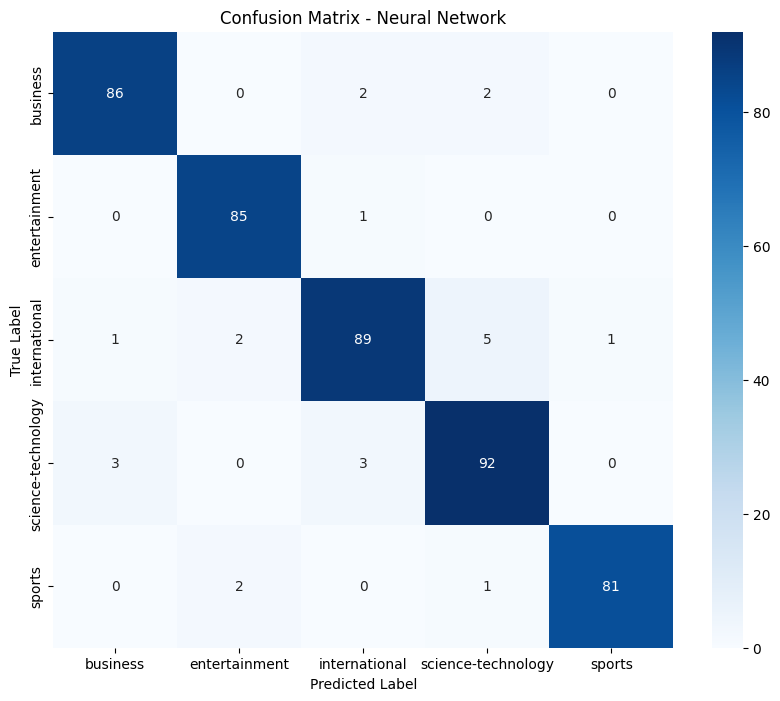

Neural Network Accuracy: 0.9496


In [41]:
accuracy_nn = evaluate_model(model, test_loader, device, int_to_label)

## Let's try to improve it:

### (i) Hyperparameter tuning:
Increasing hidden sizes and adjusting dropout

In [42]:
class EnhancedNewsClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout=0.3):
        super(EnhancedNewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

# Initialize the enhanced model
hidden_size1 = 256
hidden_size2 = 128
dropout = 0.3

model_enhanced = EnhancedNewsClassifier(input_size, hidden_size1, hidden_size2, num_classes, dropout)
model_enhanced.to(device)
print("\nEnhanced Neural Network Architecture:")
print(model_enhanced)


Enhanced Neural Network Architecture:
EnhancedNewsClassifier(
  (fc1): Linear(in_features=56800, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)


### (ii) Retrain:

In [43]:
# Define Loss Function and Optimizer for the enhanced model
criterion_enhanced = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))
optimizer_enhanced = optim.Adam(model_enhanced.parameters(), lr=0.0005)

# Training Parameters
num_epochs_enhanced = 25

# To store training and validation metrics
train_losses_enhanced = []
train_accuracies_enhanced = []
val_losses_enhanced = []
val_accuracies_enhanced = []

# Early Stopping Parameters
best_val_acc_enhanced = 0.0
best_model_wts_enhanced = copy.deepcopy(model_enhanced.state_dict())
patience_enhanced = 5
trigger_times_enhanced = 0

for epoch in range(num_epochs_enhanced):
    model_enhanced.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer_enhanced.zero_grad()
        
        # Forward pass
        outputs = model_enhanced(inputs)
        loss = criterion_enhanced(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer_enhanced.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
    
    epoch_loss = running_loss / total_predictions
    epoch_acc = correct_predictions / total_predictions
    train_losses_enhanced.append(epoch_loss)
    train_accuracies_enhanced.append(epoch_acc)
    
    # Validation
    model_enhanced.eval()
    val_running_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model_enhanced(inputs)
            loss = criterion_enhanced(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_predictions += labels.size(0)
    
    val_epoch_loss = val_running_loss / val_total_predictions
    val_epoch_acc = val_correct_predictions / val_total_predictions
    val_losses_enhanced.append(val_epoch_loss)
    val_accuracies_enhanced.append(val_epoch_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs_enhanced}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # Early Stopping
    if val_epoch_acc > best_val_acc_enhanced:
        best_val_acc_enhanced = val_epoch_acc
        best_model_wts_enhanced = copy.deepcopy(model_enhanced.state_dict())
        trigger_times_enhanced = 0
    else:
        trigger_times_enhanced += 1
        print(f'EarlyStopping counter: {trigger_times_enhanced} out of {patience_enhanced}')
        if trigger_times_enhanced >= patience_enhanced:
            print('Early stopping!')
            break

# Load best model weights
model_enhanced.load_state_dict(best_model_wts_enhanced)

Epoch [1/25] Train Loss: 1.5824, Train Acc: 0.3814 Val Loss: 1.5137, Val Acc: 0.7522
Epoch [2/25] Train Loss: 1.2451, Train Acc: 0.8816 Val Loss: 0.9296, Val Acc: 0.9386
Epoch [3/25] Train Loss: 0.4959, Train Acc: 0.9715 Val Loss: 0.3755, Val Acc: 0.9386
EarlyStopping counter: 1 out of 5
Epoch [4/25] Train Loss: 0.1501, Train Acc: 0.9858 Val Loss: 0.2488, Val Acc: 0.9430
Epoch [5/25] Train Loss: 0.0663, Train Acc: 0.9940 Val Loss: 0.2166, Val Acc: 0.9342
EarlyStopping counter: 1 out of 5
Epoch [6/25] Train Loss: 0.0345, Train Acc: 0.9978 Val Loss: 0.1983, Val Acc: 0.9408
EarlyStopping counter: 2 out of 5
Epoch [7/25] Train Loss: 0.0218, Train Acc: 0.9984 Val Loss: 0.1929, Val Acc: 0.9430
EarlyStopping counter: 3 out of 5
Epoch [8/25] Train Loss: 0.0143, Train Acc: 0.9989 Val Loss: 0.1901, Val Acc: 0.9452
Epoch [9/25] Train Loss: 0.0123, Train Acc: 0.9984 Val Loss: 0.1897, Val Acc: 0.9452
EarlyStopping counter: 1 out of 5
Epoch [10/25] Train Loss: 0.0081, Train Acc: 0.9989 Val Loss: 0.1

<All keys matched successfully>

### (iii) Evaluate new version:


Classification Report:
Class: business
  Precision: 0.95
  Recall:    0.96
  F1-Score:  0.95
  Support:   90

Class: entertainment
  Precision: 0.96
  Recall:    0.99
  F1-Score:  0.97
  Support:   86

Class: international
  Precision: 0.94
  Recall:    0.91
  F1-Score:  0.92
  Support:   98

Class: science-technology
  Precision: 0.92
  Recall:    0.93
  F1-Score:  0.92
  Support:   98

Class: sports
  Precision: 0.99
  Recall:    0.96
  F1-Score:  0.98
  Support:   84

Macro Average:
  Precision: 0.95
  Recall: 0.95
  F1_score: 0.95

Weighted Average:
  Precision: 0.95
  Recall: 0.95
  F1_score: 0.95



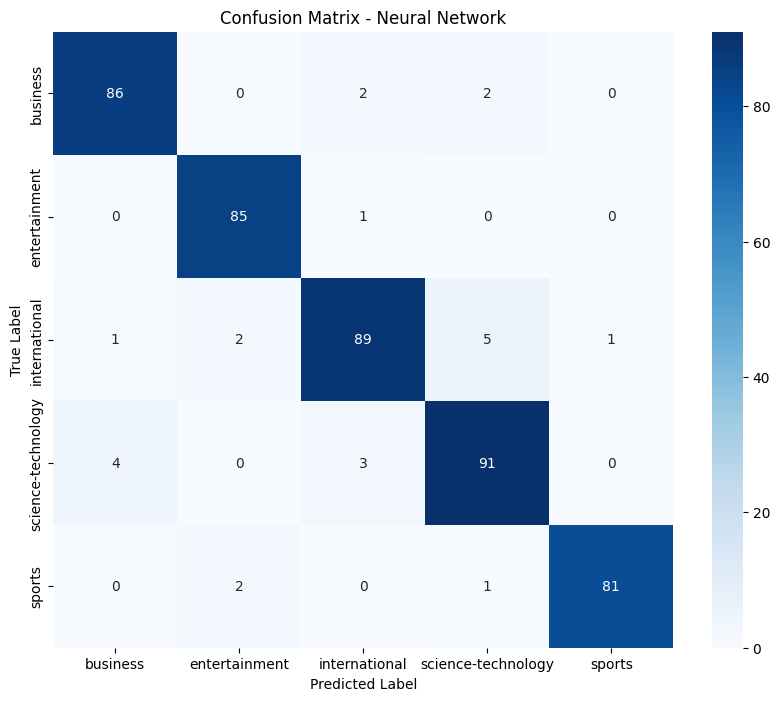

Neural Network Accuracy: 0.9474


In [44]:
accuracy_enhanced = evaluate_model(model_enhanced, test_loader, device, int_to_label)

Not much better than before, but it was worth trying... Maybe a more comprehensive list of stopwords could further improve accuracy. 